# Feature Engineering

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

In [3]:
# Adjust settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

In [4]:
# Load preprocessed dataset
data_path = '../data/interim/'
df = pd.read_csv(os.path.join(data_path, 'cleaned.csv'), index_col=[0])

In [5]:
# Create new feature for routing as dep arpt_arr arpt
df['routing'] = df['flt_dep_airpt'].astype(str) + '_' + df['flt_arr_airpt'].astype(str)

In [6]:
# Save flight crew, cabin crew names and their size in new features and drop the original variable afterwards
cp_crew = []
ca_crew = []
cp_count = []
ca_count = []

for crew in df['flt_TLC_trans']:
    cp_help = []
    ca_help = []
    for member in crew:
        if 'cp' in member:
            cp_help.append(member.partition('_')[0])
        elif 'ca' in member:
            ca_help.append(member.partition('_')[0])
    cp_crew.append(sorted(cp_help))
    ca_crew.append(sorted(ca_help))
    cp_count.append(len(cp_help))
    ca_count.append(len(ca_help))

df['cp_crew'] = cp_crew
df['ca_crew'] = ca_crew
df['cp_count'] = cp_count
df['ca_count'] = ca_count

df = df.drop(columns='flt_TLC_trans')

In [7]:
# Create two new features from flt_crew_change:
# 1. Indicator whether cabin, flight or both crews changed aircraft
# 2. Number of crew members who changed aircraft
def crew_change_cp_ca (row):
    if all(x in row['flt_crewt_change'] for x in ['ca', 'cp']):
        return 'both'
    if 'cp' in row['flt_crewt_change']:
        return 'flight_crew'
    elif 'ca' in row['flt_crewt_change']:
        return 'cabin_crew'
    else:
        return None

def crew_members (row):
    return len(row['flt_crewt_change'])

df['cc_cp_ca'] = df.apply(crew_change_cp_ca, axis=1)
df['cc_count'] = df.apply(crew_members, axis=1)

In [8]:
# Create new features for day of the week and hour of the day
df['day_of_week'] = df['flt_sched_dep'].dt.dayofweek
df['hour_of_day_dep'] = df['flt_sched_dep'].dt.hour
df['hour_of_day_arr'] = df['flt_sched_arr'].dt.hour

AttributeError: Can only use .dt accessor with datetimelike values

# Further data checks

In [9]:
# Check whether flt_crewt_change and flt_crewg match
pd.crosstab(df['flt_crewg'], df['cc_count'])

cc_count,2,6,12,18,24,30,36,42,48
flt_crewg,,,,,,,,,
A,5108,166,123,172,184,187,3,1,1
B,493,0,0,0,0,0,0,0,0
B2,0,0,0,55,60,295,15,0,0
C,0,321,184,100,97,43,1,0,0
Start,4283,0,0,0,0,0,0,0,0


There seems to be a mismatch between the variables flt_crewg and the number of crew members who changed the aircraft based on the definition of the variable flt_crewg according to the documentation:
Crew Group: assignment of what happens to the whole crew after a flight
-  Start : First flight of day
-  A : all crew members stay on the aircraft for the next flight
-  B, B2: all crew members switch aircraft for the next flight
-  C: at least one crew member switches aircraft for the next flight

For flt_crewg == A there should only be cc_count == 0 and for flt_crewg == B there should only be cc_count != 0. Therefore a further analysis is done on that.

In [10]:
# Identifying a specific aircraft wherer flt_crewg == A and cc_count != 0 to analyse the crew changes for a specific date
indexes = df[(df['flt_crewg'] == 'A') & (df['cc_count'] != 0)].index
sample = random.sample(list(indexes), 3)
print(sample)
df[(df['flt_crewg'] == 'A') & (df['cc_count'] != 0)].loc[sample]

[2180, 4912, 10946]


,flt_leg,flt_dep_airpt,flt_arr_airpt,flt_offblock,flt_onblock,flt_ac_reg,flt_change_code,flt_dep_delay,flt_ac_type,flt_tt,flt_sched_tt,flt_crewg,flt_crewt_change,flt_sched_gt,flt_act_gt,flt_sched_dep,flt_sched_arr,gnd_sched_tat,arr_delay,routing,cp_crew,ca_crew,cp_count,ca_count,cc_cp_ca,cc_count
2180,272211673,Maryland,East Carmen,2019-06-06 13:54:00,2019-06-06 15:24:00,ECLGNX,rotational problem,59.0,DH4,25,35,A,[],55.0,46.0,2019-06-06 12:55:00,2019-06-06 14:25:00,NaN,59.0,Maryland_East Carmen,[],[],0,0,None,2
4912,272014951,East Carmen,Port Maryside,2019-06-13 12:00:00,2019-06-13 13:09:00,ECLBXX,rotational problem,50.0,320,62,70,A,"['ca', 'cp', 'cp', 'ca', 'ca']",45.0,43.0,2019-06-13 11:10:00,2019-06-13 12:20:00,70.0,49.0,East Carmen_Port Maryside,[],[],0,0,both,30
10946,272025477,Coleland,East Carmen,2019-06-28 13:49:00,2019-06-28 15:16:00,ECLBJX,rotational problem,44.0,320,2,45,A,[],30.0,62.0,2019-06-28 13:05:00,2019-06-28 14:40:00,NaN,36.0,Coleland_East Carmen,[],[],0,0,None,2


In [11]:
# Now looking at the crew change history of the first registration for the specific day
df[(df['flt_ac_reg'] == 'ECLXBX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-02')].iloc[:,[11, 12, 19, 20, 21, 22, 23, 24]]

AttributeError: Can only use .dt accessor with datetimelike values

Based on the hypothesis that the names of the crews are being recorded correctly as this might not only be relevant for payroll accounting but also from regulative perspective the flt_crewg and flt_crewt_change values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
400 | A | [] |
432 | C | [ca] |
489 | B | [cp, cp, ca, ca, ca, ca] |
543 | C | [ca] |
599 | A | [] |
1137 | NaN | NaN |

In [ ]:
# Let's have a detailed look at the second example
df[(df['flt_ac_reg'] == 'ECLGBX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-28')].iloc[:,[11, 12, 19, 20, 21, 22, 23, 24]]

For the second example the values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
10705 | B | [cp, cp, ca, ca] |
10738 | A | [] |
10782 | C | [cp, cp, ca] |
10810 | B | [cp, cp, ca, ca] |
10862 | C | [cp, cp] |
10899 | A | [] |
10932 | A | [] |
10988 | B | [cp, cp, ca, ca] |
11031 | A | [] |
11061 | A | [] |
11106 | NaN | NaN |

In [ ]:
# Let's have a detailed look at the third example
df[(df['flt_ac_reg'] == 'ECLGRX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-05')].iloc[:,[11, 12, 19, 20, 21, 22, 23, 24]]

For the second example the values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
1593 | A | [] |
1655 | B | [cp, cp, ca, ca] |
1739 | A | [] |
1781 | C | [ca] |
1824 | A | [] |
1874 | A | [] |
1921 | NaN | Nan |

Within this sample only a few entries in flt_crewg and flt_crewt_change match with the data crew data over the rotation of a single registration over a day. Furthermore, there is a general error in the variable flt_crewg as it always shows Start for the first leg of the day, however the variable shall state "what happens to the whole crew after a flight".
Due to this new features to capture crew changes will be established based on the columns cp_crew and ca_crew for the rotation of a specific aircraft on any given day.

In [12]:
# Creating new features to track crew changes from the flight before: cc_type {0: Start - First flight of the day, 1: No crew change;
# 2: At least one member but not all of the crew changed; 3: Whole crew changed}; cc_roles [list of elements either ca or cp with an
# entry for every crew member that changed aircraft]

# Furthermore routing check could be included and update of cc_count and cc_ca_cp could be incorporated

def crew_changes (registrations):
    # Create an empty df that will be appended in every step and finally returned by the function
    cc = pd.DataFrame(columns=['cc_types', 'cc_roles'])
    # Loop through the aircrafts and sort their flights by sched_dep
    for aircraft in registrations:
        indexes = df[df['flt_ac_reg'] == aircraft].sort_values(by='flt_sched_dep').index
        date = '2019-01-01'
        # Loop through the indexes of a specific aircraft
        for idx in indexes:
            cc_roles = []
            # If index has new date and therefore is first flight of the day
            if date not in str(df['flt_sched_dep'].loc[idx]):
                date = str(df['flt_sched_dep'].loc[idx]).partition(' ')[0]
                cp = df['cp_crew'].loc[idx]
                ca = df['ca_crew'].loc[idx]
                help = pd.DataFrame([[0, []]], columns=['cc_types', 'cc_roles'], index=[idx])
            else:
                # Check differences between flight and cabin crew from previous flight
                dif_cp = list(set(cp) - set(df['cp_crew'].loc[idx]))
                dif_ca = list(set(ca) - set(df['ca_crew'].loc[idx]))
                # If no crew members changed
                if (len(dif_cp) == 0) and (len(dif_ca) == 0):
                    help = pd.DataFrame([[1, []]], columns=['cc_types', 'cc_roles'], index=[idx])
                # If all crew members changed
                elif (len(dif_cp) >= len(cp)) and (len(dif_ca) >= len(ca)):
                    for item in dif_cp:
                        cc_roles.append('cp')
                    for item in dif_ca:
                        cc_roles.append('ca')
                    help = pd.DataFrame([[3, cc_roles]], columns=['cc_types', 'cc_roles'], index=[idx])
                else:
                    for item in dif_cp:
                        cc_roles.append('cp')
                    for item in dif_ca:
                        cc_roles.append('ca')
                    help = pd.DataFrame([[2, cc_roles]], columns=['cc_types', 'cc_roles'], index=[idx])
                cp = df['cp_crew'].loc[idx]
                ca = df['ca_crew'].loc[idx]
            cc = cc.append(help)
    return cc

# Create a list of all registrations in the dataset
registrations = df['flt_ac_reg'].unique()

df = pd.merge(df, crew_changes(registrations), left_index=True, right_index=True)
# Finally drop old columns
df = df.drop(columns=['flt_crewg', 'flt_crewt_change'])

# Visual data analysis

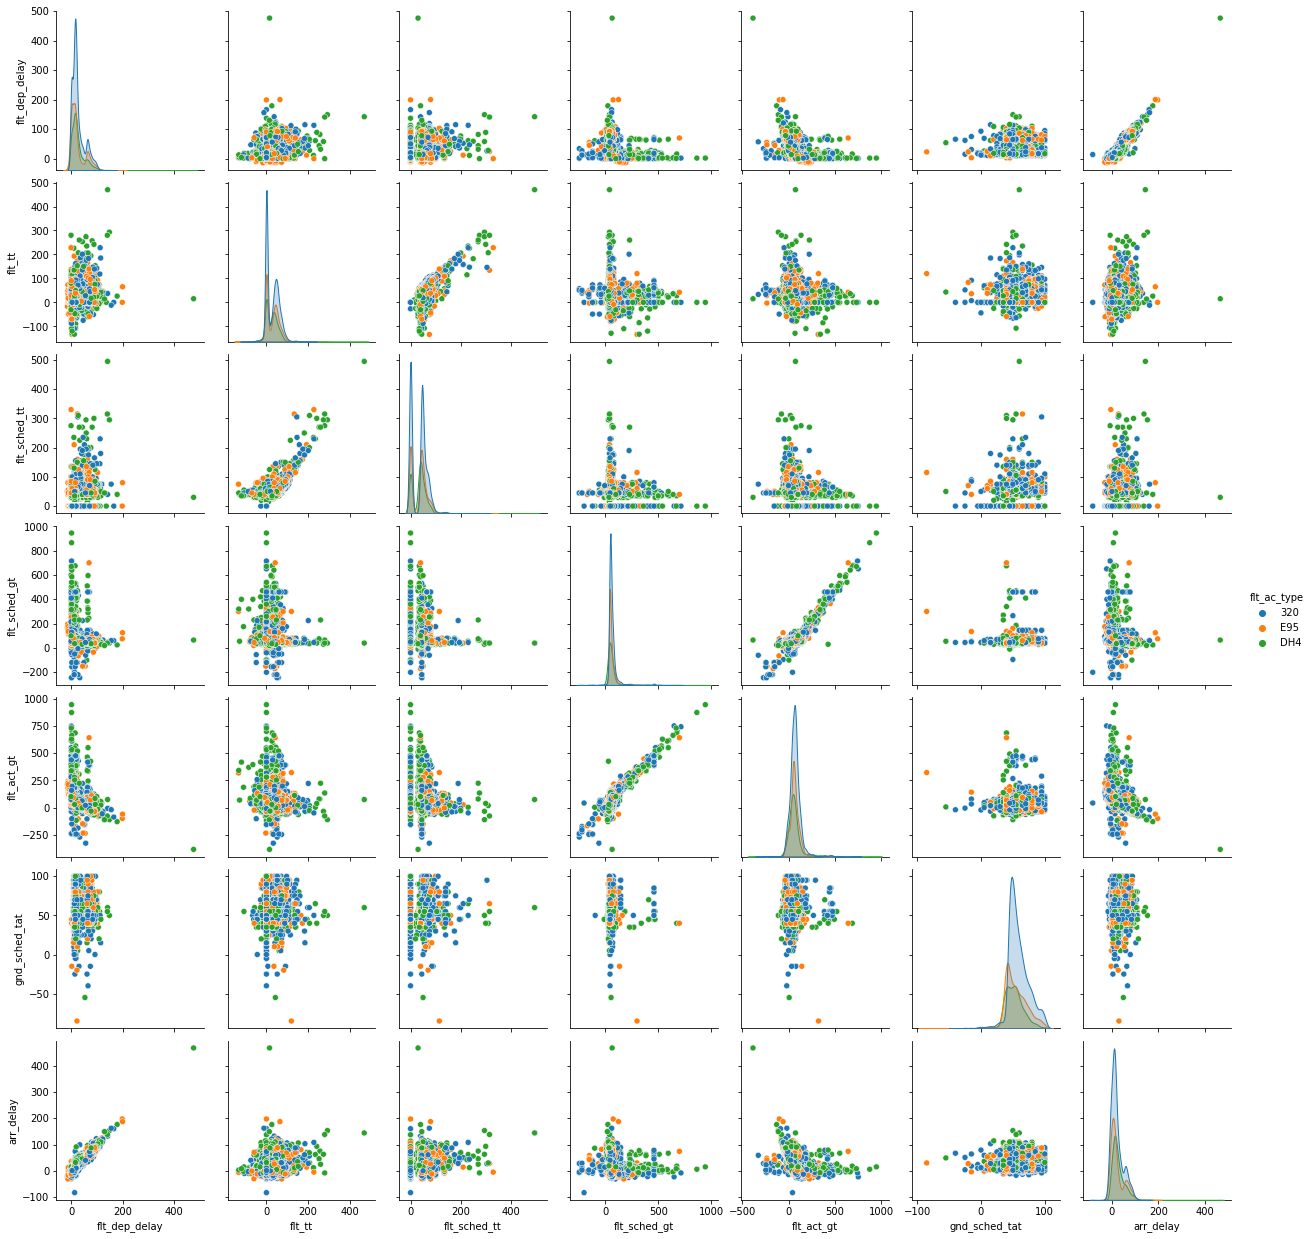

In [13]:
# Pairplot of all numerical values including dependent variable
data = df[['flt_dep_delay', 'flt_tt', 'flt_sched_tt', 'flt_sched_gt', 'flt_act_gt', 'gnd_sched_tat', 'arr_delay']]
sns.pairplot(df, hue='flt_ac_type', vars=data, diag_kind='kde')

<AxesSubplot:>

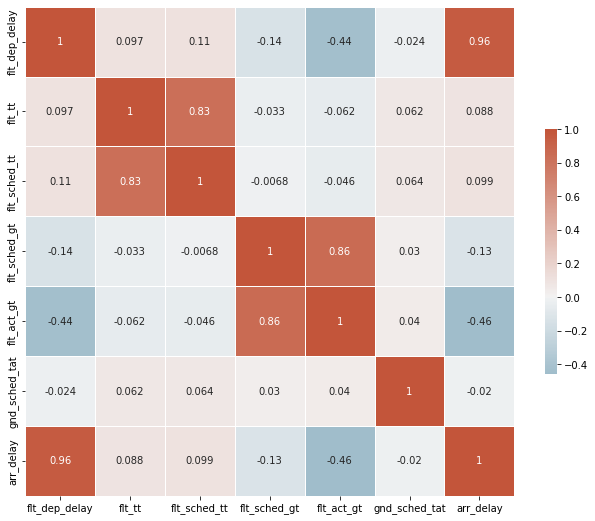

In [14]:
corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
# Heatmap for day of week, hour of day and arr_delay
data = df.pivot_table(index='hour_of_day_dep', columns='day_of_week', values='arr_delay', aggfunc=np.mean)
f, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(data, annot=True,linewidths=.5, ax=ax)

KeyError: 'hour_of_day_dep'

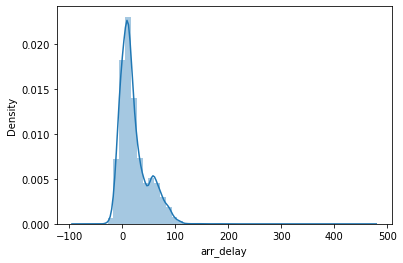

In [16]:
# Plot histogram of dependent variable including pdf
sns.distplot(df['arr_delay'], kde=True);